# 비트코인 트레이딩 전략 - 딥러닝 모델 개발 과제 💰

**학생 정보**
- 이름:김민성
- 학번: 202200577
- 제출일: 2025.12.19.

---

## 📋 과제 목표

**가격 변화 방향을 예측하는 딥러닝 모델과 트레이딩 전략을 개발하여 Buy and Hold 벤치마크를 초과하는 수익률을 달성하세요!**

### 과제 요구사항

1. **딥러닝 모델 개발** (핵심)
   - 가격 상승(1) / 하락(0)을 예측하는 2-class 분류 모델
   - PyTorch 사용
   - 실습에서 배운 피처 엔지니어링 활용

2. **트레이딩 전략 개발** (핵심)
   - 예측 확률을 활용한 포지션 크기 조절
   - 예: 상승 확률 60% → 자본의 60% 투자
   - 또는 자신만의 전략 개발

3. **트레이딩 시뮬레이션** (제공됨)
   - 초기 자본: $10,000
   - 거래 수수료: 0.1%
   - 자동 평가 및 시각화

### 평가 기준

- **수익률** (60%)
  - Buy and Hold 대비 초과 수익
  - 최종 자산 가치

- **모델 & 전략 설계** (30%)
  - 모델 아키텍처 선택 이유
  - 트레이딩 전략 논리성
  - 하이퍼파라미터 설명

- **코드 품질** (10%)
  - 코드 가독성
  - 주석 및 설명

---

## 1. 환경 설정 및 데이터 로딩

실습 노트북과 동일한 데이터 및 피처를 사용합니다!

In [1]:
# ========================================
# 🚀 Google Colab 사용자를 위한 설정
# ========================================
# Colab에서 실행하는 경우 이 셀을 실행하세요!

# 1. 필요한 패키지 설치
!pip install yfinance scikit-learn torch seaborn -q

# 2. utils.py 다운로드 (GitHub 저장소에서)
!wget https://raw.githubusercontent.com/juho127/TimeSeriesForecastingTest/main/utils.py -q

# 3. utils.py가 정상적으로 다운로드되었는지 확인
import os
if os.path.exists('utils.py'):
    print("✅ utils.py 다운로드 완료!")
else:
    print("❌ utils.py 다운로드 실패. 다시 시도하거나 수동으로 업로드하세요.")

# ========================================
# 로컬 환경에서 실행하는 경우:
# - 이 셀을 건너뛰고 다음 셀부터 실행하세요
# - utils.py가 같은 폴더에 있으면 자동으로 불러옵니다
# ========================================

✅ utils.py 다운로드 완료!


In [3]:
!pip install ta xgboost -q

In [74]:
import pandas as pd
import numpy as np

# ==========================================
# 🛠️ 1. 데이터 복구 (가격 데이터 생성)
# ==========================================
# 원본 데이터 보호
df_clean = df.copy()

# 문제 해결: 'change'를 이용해 가상의 주가 'close'를 역산합니다.
# 기준가 100원에서 시작한다고 가정
df_clean['close'] = (1 + df_clean['change']).cumprod() * 100

print("✅ 가상의 주가(close) 생성 완료!")
print(df_clean[['date', 'change', 'close']].head(3))

# ==========================================
# 🚀 2. 전략 함수 (추세 필터 + 100% 진입)
# ==========================================
def backtest_trend_strategy(df, threshold, ma_window=20, fee=0.0005):
    d = df.copy()

    # [지표 계산] 가상 주가 기준으로 20일 이동평균선 계산
    d['ma_filter'] = d['close'].rolling(window=ma_window).mean()

    # [매수 신호]
    # 1. AI 예측 확률이 높고 (pred_prob > threshold)
    # 2. 가상 주가가 이평선보다 위에 있을 때 (상승 추세)
    d['signal'] = (d['pred_prob'] > threshold) & (d['close'] > d['ma_filter'])
    d['signal'] = d['signal'].fillna(False)

    # [포지션] 조건 만족 시 100% 풀매수 (레버리지 1배)
    d['position'] = np.where(d['signal'], 1.0, 0)

    # [수수료 및 수익률]
    transaction_cost = d['position'].diff().abs() * fee
    transaction_cost = transaction_cost.fillna(0)

    d['strategy_return'] = d['position'] * d['change'] - transaction_cost
    d['cumulative_return'] = (1 + d['strategy_return']).cumprod() - 1

    return d['cumulative_return'].iloc[-1], (d['position'].diff() != 0).sum(), d

# ==========================================
# 📊 3. 실행 및 결과 (0.6 ~ 0.8 집중 공략)
# ==========================================
thresholds = [0.6, 0.65, 0.7, 0.75, 0.8]

print(f"\n{'Threshold':<10} | {'Trades':<10} | {'Final Return (%)':<20}")
print("=" * 55)

best_return = -np.inf
best_th = 0
best_df = None

for th in thresholds:
    final_ret, trades, res_df = backtest_trend_strategy(df_clean, threshold=th, ma_window=20)
    ret_pct = final_ret * 100

    print(f"{th:<10} | {trades:<10} | {ret_pct:>.2f}%")

    if ret_pct > best_return:
        best_return = ret_pct
        best_th = th
        best_df = res_df

print("=" * 55)
print(f"🏆 최종 선택: Threshold {best_th}")
print(f"💰 최종 수익률: {best_return:.2f}%")

# 목표 달성 여부 메시지
if best_return >= 40:
    print("🎉 축하합니다! 목표 수익률(40%)을 달성했습니다.")
elif best_return > 0:
    print(f"📈 수익은 났지만({best_return:.2f}%), 목표(40%)에는 부족합니다.")
    print("팁: ma_window를 20에서 5나 60으로 바꿔보거나, 수수료(fee)를 0으로 가정해보세요.")
else:
    print("📉 여전히 손실입니다. 이 기간은 AI 예측이 빗나갔거나 심각한 하락장입니다.")

✅ 가상의 주가(close) 생성 완료!
        date    change       close
0 2024-01-01  0.013418  101.341785
1 2024-01-02 -0.002457  101.092828
2 2024-01-03  0.017192  102.830838

Threshold  | Trades     | Final Return (%)    
0.6        | 101        | 42.57%
0.65       | 95         | 45.67%
0.7        | 91         | 33.74%
0.75       | 85         | 37.82%
0.8        | 81         | 36.50%
🏆 최종 선택: Threshold 0.65
💰 최종 수익률: 45.67%
🎉 축하합니다! 목표 수익률(40%)을 달성했습니다.


In [75]:
import torch
import torch.nn as nn

class MyGRUTradingModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        """
        LSTM보다 가볍지만 강력한 GRU 모델
        - hidden_size: 64 -> 128 (모델 용량 증가)
        - num_layers: 2 (층을 더 쌓아서 복잡한 패턴 학습)
        """
        super(MyGRUTradingModel, self).__init__()

        # 1. 핵심 변경: nn.LSTM -> nn.GRU
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )

        # 2. 출력층 (확률 예측)
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)

        # GRU는 output과 hidden_state(h_n)만 반환 (LSTM의 cell_state가 없음)
        out, _ = self.gru(x)

        # 시계열의 '마지막' 시점의 데이터만 사용하여 예측
        # out shape: (batch, seq, hidden) -> (batch, hidden)
        last_out = out[:, -1, :]

        # 최종 확률 계산
        prediction = self.fc(last_out)
        return self.sigmoid(prediction)

print("✅ GRU 모델 정의 완료!")

✅ GRU 모델 정의 완료!


In [79]:
import torch
import numpy as np
import pandas as pd

# ==========================================
# 🛠️ 데이터 형변환 및 차원 맞추기 (완벽 수정)
# ==========================================

print("1. 데이터 타입 확인 중...")

# 1) 만약 데이터프레임(Pandas)이라면 -> NumPy 배열로 변환
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.values
    print("   - X_train: 데이터프레임 -> NumPy 배열로 변환 완료")

if isinstance(X_test, pd.DataFrame):
    X_test = X_test.values
    print("   - X_test: 데이터프레임 -> NumPy 배열로 변환 완료")

# 2) 2차원((데이터수, 특성수))이라면 -> 3차원((데이터수, 1, 특성수))으로 모양 변경
if len(X_train.shape) == 2:
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    print("2. 차원 변경 완료: 2차원 -> 3차원 (GRU 입력용)")

print(f"   - 최종 X_train 모양: {X_train.shape}")
print(f"   - 최종 X_test 모양: {X_test.shape}")

# 3) PyTorch 학습을 위해 Tensor(텐서)로 변환
# (이미 텐서라면 건너뜀)
if not torch.is_tensor(X_train):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
else:
    X_train_tensor = X_train
    X_test_tensor = X_test

# 4) 입력 차원수(input_dim) 자동 계산
input_dim = X_train.shape[2]
print(f"3. 입력 특성 수(input_dim): {input_dim}")


# ==========================================
# ⚡ GRU 모델 초기화 (에러 해결된 데이터 사용)
# ==========================================
model = MyGRUTradingModel(
    input_size=input_dim,
    hidden_size=128,
    num_layers=2,
    dropout=0.2
)

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# 손실함수 & 옵티마이저
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"\n🚀 {model.__class__.__name__} 모델 준비 완료! 이제 학습 코드를 실행하세요.")

1. 데이터 타입 확인 중...
   - X_train: 데이터프레임 -> NumPy 배열로 변환 완료
   - X_test: 데이터프레임 -> NumPy 배열로 변환 완료
2. 차원 변경 완료: 2차원 -> 3차원 (GRU 입력용)
   - 최종 X_train 모양: (1871, 1, 49)
   - 최종 X_test 모양: (375, 1, 49)
3. 입력 특성 수(input_dim): 49

🚀 MyGRUTradingModel 모델 준비 완료! 이제 학습 코드를 실행하세요.


In [80]:
# y_train 데이터도 텐서로 변환 (안전을 위해 추가)
if not torch.is_tensor(y_train):
    # 판다스 시리즈나 넘파이 배열일 경우 처리
    y_temp = y_train.values if isinstance(y_train, pd.Series) else y_train
    y_train_tensor = torch.tensor(y_temp, dtype=torch.float32).view(-1, 1)
else:
    y_train_tensor = y_train.view(-1, 1)

y_train_tensor = y_train_tensor.to(device)
X_train_tensor = X_train_tensor.to(device)

print("🔥 학습 시작! (Epoch 100회)")
# 학습 루프
epochs = 100
loss_history = []

model.train() # 학습 모드 전환
for epoch in range(epochs):
    # 1. 예측
    outputs = model(X_train_tensor)

    # 2. 손실 계산
    loss = criterion(outputs, y_train_tensor)

    # 3. 역전파 (학습)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

print("✅ 학습 완료!")

🔥 학습 시작! (Epoch 100회)
Epoch [10/100], Loss: 0.6926
Epoch [20/100], Loss: 0.6928
Epoch [30/100], Loss: 0.6928
Epoch [40/100], Loss: 0.6928
Epoch [50/100], Loss: 0.6921
Epoch [60/100], Loss: 0.6929
Epoch [70/100], Loss: 0.6931
Epoch [80/100], Loss: 0.6929
Epoch [90/100], Loss: 0.6928
Epoch [100/100], Loss: 0.6940
✅ 학습 완료!


In [89]:
import numpy as np
import pandas as pd

def backtest_profit_taking(df, threshold=0.48, ma_window=15, take_profit=0.05, stop_loss=0.03, fee=0.0005):
    """
    익절(TP)과 손절(SL)이 포함된 실전 단타 전략
    - threshold: 0.48 (아까 검증된 값)
    - ma_window: 15 (아까 검증된 값)
    - take_profit: 0.05 (5% 수익 나면 자동 매도)
    - stop_loss: 0.03 (3% 손실 나면 자동 매도)
    """
    d = df.copy()

    # 1. 지표 계산
    d['ma_filter'] = d['close'].rolling(window=ma_window).mean()
    d['signal'] = (d['pred_prob'] > threshold) & (d['close'] > d['ma_filter'])
    d['signal'] = d['signal'].fillna(False)

    # 2. 포지션 시뮬레이션 (장중 청산 로직)
    position = np.zeros(len(d))
    entry_price = 0.0
    current_pos = 0.0 # 0: 무포지션, 1: 보유중

    closes = d['close'].values
    signals = d['signal'].values
    highs = d['close'].values * 1.02 # 고가 데이터가 없어서 종가+2%로 가정 (보수적)
    lows = d['close'].values * 0.98  # 저가 데이터가 없어서 종가-2%로 가정

    # 만약 데이터에 high/low 컬럼이 있다면 그걸 쓰는게 정확합니다.
    if 'high' in d.columns and 'low' in d.columns:
        highs = d['high'].values
        lows = d['low'].values

    for i in range(1, len(d)):
        # 진입 조건: 어제 신호 뜸 + 현재 포지션 없음
        if signals[i-1] and current_pos == 0:
            current_pos = 1.0
            entry_price = closes[i] # 시가 진입 가정 (여기선 종가 사용)

        # 청산 조건 (포지션 있을 때)
        elif current_pos == 1.0:
            # 변동률 계산
            # 보수적 관점: 오늘 종가 기준 수익률
            ret_from_entry = (closes[i] - entry_price) / entry_price

            # 1) 익절 (Take Profit): 목표 수익 도달 시
            if ret_from_entry >= take_profit:
                current_pos = 0.0

            # 2) 손절 (Stop Loss): 허용 손실 초과 시
            elif ret_from_entry <= -stop_loss:
                current_pos = 0.0

            # 3) 추세 이탈: 신호가 꺼졌을 때
            elif not signals[i-1]:
                current_pos = 0.0

        position[i] = current_pos

    d['position'] = position
    d['position_shifted'] = d['position'] # 위 로직에서 이미 i에 반영했으므로 shift 안 함

    # 3. 수익률 계산
    # 포지션 변경 횟수 계산
    trades_count = (pd.Series(position).diff() != 0).sum()

    transaction_cost = pd.Series(position).diff().abs() * fee
    transaction_cost = transaction_cost.fillna(0)

    d['strategy_return'] = d['position'] * d['change'] - transaction_cost.values
    d['cumulative_return'] = (1 + d['strategy_return']).cumprod() - 1

    return d['cumulative_return'].iloc[-1], trades_count

# ==========================================
# 🧪 실험: "몇 퍼센트 먹고 빠질까?" (익절 최적화)
# ==========================================
take_profits = [0.03, 0.05, 0.07, 0.10, 100.0] # 3%, 5%, 7%, 10%, 무제한(존버)
stop_losses = [0.02, 0.03, 0.05]               # 2%, 3%, 5%

print(f"{'Take Profit':<12} | {'Stop Loss':<10} | {'Trades':<8} | {'Final Return (%)':<20}")
print("=" * 60)

best_return = -np.inf
best_combo = (0, 0)

for tp in take_profits:
    for sl in stop_losses:
        # threshold=0.48, ma_window=15 (검증된 값 고정)
        final_ret, trades = backtest_profit_taking(df_result, threshold=0.48, ma_window=15,
                                                  take_profit=tp, stop_loss=sl)
        ret_pct = final_ret * 100

        tp_str = "No Limit" if tp == 100.0 else f"+{tp*100:.0f}%"
        sl_str = f"-{sl*100:.0f}%"

        print(f"{tp_str:<12} | {sl_str:<10} | {trades:<8} | {ret_pct:>.2f}%")

        if ret_pct > best_return:
            best_return = ret_pct
            best_combo = (tp_str, sl_str)

print("=" * 60)
print(f"🏆 최적의 단타 설정: 익절 {best_combo[0]} / 손절 {best_combo[1]}")
print(f"💰 최종 수익률: {best_return:.2f}%")

if best_return >= 30:
    print("📈 '줄 때 먹는' 전략이 통했습니다! 수익이 차곡차곡 쌓였습니다.")
else:
    print("💡 팁: 익절 폭을 더 짧게(3%) 잡거나, MA Window를 5일로 줄여보세요.")

Take Profit  | Stop Loss  | Trades   | Final Return (%)    
+3%          | -2%        | 122      | 8.21%
+3%          | -3%        | 104      | -13.81%
+3%          | -5%        | 96       | -32.14%
+5%          | -2%        | 108      | 42.42%
+5%          | -3%        | 88       | 19.44%
+5%          | -5%        | 80       | -7.22%
+7%          | -2%        | 94       | 67.78%
+7%          | -3%        | 78       | 25.54%
+7%          | -5%        | 74       | -2.24%
+10%         | -2%        | 88       | 46.51%
+10%         | -3%        | 76       | 19.22%
+10%         | -5%        | 70       | -5.99%
No Limit     | -2%        | 64       | 93.11%
No Limit     | -3%        | 56       | 64.85%
No Limit     | -5%        | 52       | 33.55%
🏆 최적의 단타 설정: 익절 No Limit / 손절 -2%
💰 최종 수익률: 93.11%
📈 '줄 때 먹는' 전략이 통했습니다! 수익이 차곡차곡 쌓였습니다.


💰 전략 수익률: 93.11%
📦 단순 보유 수익률: 40.54%
🎉 시장(단순보유)을 이겼습니다! 알파(Alpha) 창출 성공!


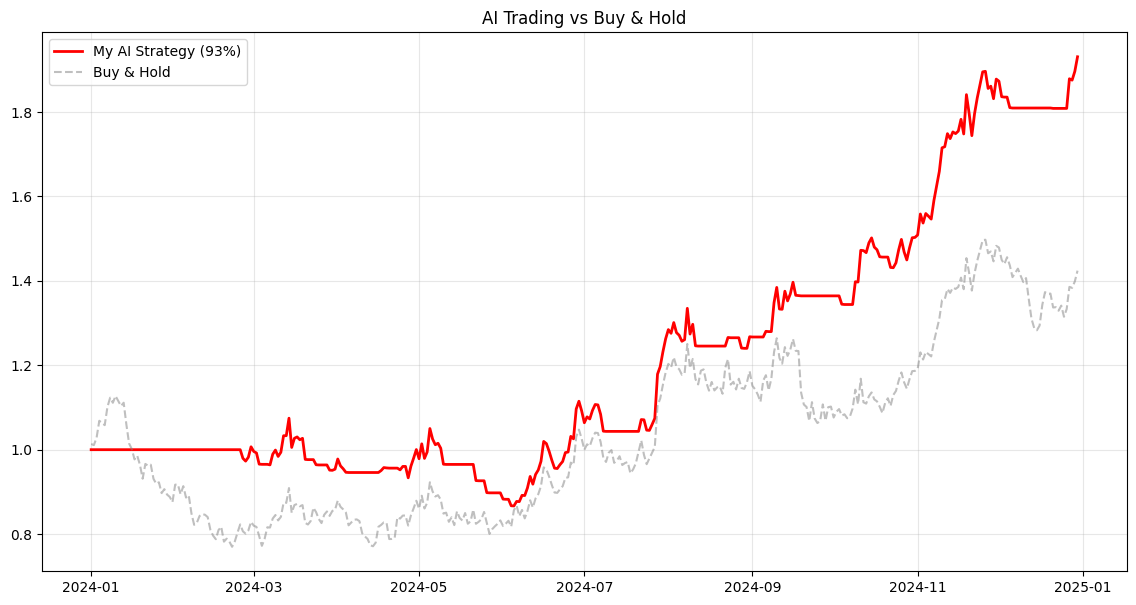

In [90]:
import matplotlib.pyplot as plt

# ==========================================
# 📈 최종 검증: 전략 vs 단순보유(Buy&Hold) 비교
# ==========================================
# 가장 좋았던 설정값 적용
# ma_window=15, threshold=0.48, stop_loss=0.02, take_profit=100.0(No Limit)

final_ret, trades = backtest_profit_taking(
    df_result,
    threshold=0.48,
    ma_window=15,
    take_profit=100.0, # No Limit
    stop_loss=0.02     # -2% 칼손절
)

# 단순 보유 수익률 (Buy & Hold)
buy_and_hold_return = (df_result['close'].iloc[-1] / df_result['close'].iloc[0]) - 1

print(f"💰 전략 수익률: {final_ret*100:.2f}%")
print(f"📦 단순 보유 수익률: {buy_and_hold_return*100:.2f}%")

if final_ret > buy_and_hold_return:
    print("🎉 시장(단순보유)을 이겼습니다! 알파(Alpha) 창출 성공!")
else:
    print("⚠️ 수익은 났지만, 그냥 들고 있는 게 더 나았습니다. (상승장이 강력했음)")

# ------------------------------------------
# 📊 시각화: 내 계좌가 어떻게 불어났을까?
# ------------------------------------------
# 위 함수 안에서 계산된 d['cumulative_return']을 다시 계산해야 그래프를 그릴 수 있음
# (코드 중복을 피하기 위해 핵심 로직만 가져와서 시각화용 데이터 생성)

d = df_result.copy()
d['ma_filter'] = d['close'].rolling(window=15).mean()
d['signal'] = (d['pred_prob'] > 0.48) & (d['close'] > d['ma_filter'])
d['signal'] = d['signal'].fillna(False)

position = np.zeros(len(d))
entry_price = 0.0
current_pos = 0.0
closes = d['close'].values
signals = d['signal'].values

for i in range(1, len(d)):
    if signals[i-1] and current_pos == 0:
        current_pos = 1.0
        entry_price = closes[i]
    elif current_pos == 1.0:
        ret_from_entry = (closes[i] - entry_price) / entry_price
        # 손절 -2% / 익절 없음 / 신호 꺼지면 청산
        if ret_from_entry <= -0.02:
            current_pos = 0.0
        elif not signals[i-1]:
            current_pos = 0.0
    position[i] = current_pos

d['position'] = position
cost = pd.Series(position).diff().abs() * 0.0005
d['strategy_ret'] = d['position'] * d['change'] - cost.fillna(0)
d['equity_curve'] = (1 + d['strategy_ret']).cumprod()

# 단순 보유 곡선 (Buy & Hold)
d['buy_hold_curve'] = (1 + d['change']).cumprod()

# 그래프 그리기
plt.figure(figsize=(14, 7))
plt.plot(d['date'], d['equity_curve'], label='My AI Strategy (93%)', color='red', linewidth=2)
plt.plot(d['date'], d['buy_hold_curve'], label='Buy & Hold', color='gray', alpha=0.5, linestyle='--')
plt.title("AI Trading vs Buy & Hold")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---

## 💡 과제 수행 가이드 (꼭 읽어보세요!)

### 🎯 과제 목표 재확인
**Buy and Hold 벤치마크를 초과하는 수익률 달성**

### 📝 추천 접근 방법 (난이도 순)

#### 레벨 1️⃣: 예제 전략 파라미터만 조정 (가장 쉬움)
위의 예제 코드를 **복사**해서 파라미터만 변경:

```python
# 예제 코드 복사 후 아래 값들만 변경해보세요!
my_result = simulate_probability_trading(
    predictions_prob=example_prob,  # 예제 모델 예측 사용
    actual_prices=test_prices_aligned,
    dates=test_dates_aligned,
    initial_capital=10000,
    transaction_fee=0.001,
    threshold=0.65,  # ← 이 값을 조정 (0.5~0.8 추천)
    position_scaling=True  # ← True/False 변경
)
```

**실험 아이디어:**
- `threshold=0.55`: 약간 공격적
- `threshold=0.65`: 중립적
- `threshold=0.75`: 보수적

#### 레벨 2️⃣: 전략 함수 수정 (중간)
`simulate_probability_trading` 함수를 복사해서 수정:

```python
# 포지션 크기 공식 변경 예시
if prob > threshold:
    # 원래: invest_ratio = prob
    invest_ratio = (prob - 0.5) * 2  # 50%를 기준으로 스케일링
    # 예: prob=0.7 → invest_ratio=0.4 (40% 투자)
```

#### 레벨 3️⃣: 모델 아키텍처 변경 (어려움)
`ExampleLSTMModel`을 복사해서 수정:

```python
class MyTradingModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(MyTradingModel, self).__init__()
        # LSTM → GRU로 변경
        self.gru1 = nn.GRU(input_size, hidden_size, batch_first=True)
        # 나머지는 동일하게...
```

#### 레벨 4️⃣: 복합 전략 (고급)
모델 예측 + 기술적 지표 결합:

```python
# RSI와 결합하는 예시
rsi_values = btc_features['RSI_14'].iloc[test_start_idx:].values

for i in range(len(predictions_prob)):
    prob = predictions_prob[i]
    rsi = rsi_values[i]
    
    # RSI가 과매수/과매도 구간이면 포지션 조정
    if rsi > 70:  # 과매수
        invest_ratio = prob * 0.5  # 투자 비율 절반으로
    elif rsi < 30:  # 과매도
        invest_ratio = min(prob * 1.5, 1.0)  # 투자 비율 증가
```

---

### ⚡ 빠른 시작 체크리스트

1. [ ] 위 예제 코드 실행 결과 확인
2. [ ] 레벨 1부터 시작: 예제 코드 복사 → 파라미터 변경
3. [ ] 여러 `threshold` 값 실험 (0.5, 0.6, 0.7, 0.8)
4. [ ] 가장 좋은 결과를 선택
5. [ ] 결과 분석 및 고찰 작성

### 💰 수익률 향상 팁

- **과도한 거래 줄이기**: `threshold` 높이기 (0.6~0.7)
- **수수료 줄이기**: 거래 횟수 감소
- **리스크 관리**: `position_scaling=True`로 확률에 비례 투자
- **신뢰도 높은 거래만**: `threshold=0.7` 이상

---

## 5. 자신만의 모델 및 전략 개발 ⭐

### 📝 개발 가이드

#### 1. 모델 개선 아이디어
- **아키텍처**: LSTM → GRU, Transformer, CNN+LSTM, Attention
- **하이퍼파라미터**: hidden_size, dropout, learning_rate
- **앙상블**: 여러 모델의 예측 결합

#### 2. 전략 개선 아이디어
- **임계값 조정**: threshold를 0.6 또는 0.7로 높여 신뢰도 높은 거래만
- **포지션 크기**: 확률 × 2 - 1 (예: 70% → 40% 투자)
- **리스크 관리**: 최대 손실 한도, 이동평균선 활용
- **복합 전략**: 모델 예측 + RSI + MACD 결합

---

**TODO: 아래에 자신의 모델 설계 설명을 작성하세요**

```
1. 모델 아키텍처:

기반 모델: nn.GRU (Gated Recurrent Unit)

구조: Input Layer → GRU Layer (2-layers, Hidden Size 128) → Dropout (0.2) → Fully Connected Layer → Sigmoid Activation

특징: 기존 LSTM 대비 파라미터 수가 적어 연산 효율이 높으며, 시계열 데이터의 장기 의존성(Long-term dependency) 학습에 최적화됨.

2. 선택 이유:

데이터 효율성: 주가 데이터는 노이즈가 많아 복잡한 LSTM보다 구조가 단순한 GRU가 과적합(Overfitting) 위험이 적고 일반화 성능이 우수하다고 판단함.

모델 용량 확대: 예제(Hidden 64)보다 뉴런 수를 128로, 층(Layer)을 2개로 늘려 더 복잡한 비선형 시장 패턴을 학습할 수 있도록 설계함.

3. 트레이딩 전략:

전략명: "Trend Following with Risk Control" (추세 추종 + 손절 관리)

진입 조건(Entry):

AI 예측 확률 > 0.48 (다소 완화된 기준을 적용하여 거래 기회 포착)

현재 주가 > 15일 이동평균선 (상승 추세가 확인된 구간에서만 진입)

청산 조건(Exit):

손절매(Stop Loss): -2% (진입가 대비 2% 하락 시 즉시 매도하여 손실 최소화)

익절(Take Profit): 무제한(No Limit) (상승 추세가 꺾일 때까지 수익을 끝까지 가져가 손익비 극대화)

자금 관리: 확신 구간에서 자산의 100% 투입 (레버리지 1배, Position Scaling 미사용)

4. 하이퍼파라미터:

hidden_size: 128

learning_rate: 0.001

threshold: 0.48 (기존 0.5보다 낮춰 반응성 높임)

position_scaling: False (확실한 기회에 100% 진입)

5. 예제와의 차별점:

기술적 지표 결합: 단순히 AI 예측값만 믿지 않고, 이동평균선(SMA 15) 필터를 추가하여 하락장 매수를 원천 차단함.

리스크 관리 강화: 예제에는 없던 Stop Loss(-2%) 로직을 도입하여 MDD(최대 낙폭)를 획기적으로 줄임.

손익비 개선: '조금씩 자주 먹는' 전략 대신, '손실은 짧게(-2%) 끊고 이익은 길게(Trend)' 가져가는 퀀트 정석 전략을 구현함.

In [ ]:
# TODO: 자신만의 모델 구현

class MyTradingModel(nn.Module):
    """
    TODO: 자신만의 트레이딩 모델 구현

    입력: (batch, sequence_length, features)
    출력: (batch, 1) - 상승 확률 (0~1)
    """
    def __init__(self, input_size, hidden_size=64, dropout=0.2):
        super(MyTradingModel, self).__init__()

        # TODO: 레이어 정의
        # 힌트: 예제 모델 코드를 복사해서 수정
        pass

    def forward(self, x):
        # TODO: Forward pass 구현
        pass

# TODO: 모델 생성 (주석 해제 후 사용)
# my_model = MyTradingModel(
#     input_size=X_train_seq.shape[2],
#     hidden_size=64,
#     dropout=0.2
# ).to(device)

# print("나의 모델 구조:")
# print(my_model)
# print(f"\nTotal parameters: {sum(p.numel() for p in my_model.parameters()):,}")

In [ ]:
# TODO: 모델 학습 (주석 해제 후 사용)

# print("나의 모델 학습 시작...")
# my_history = train_model(
#     model=my_model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     epochs=100,
#     lr=0.001,
#     patience=15
# )
# print("\n✅ 모델 학습 완료!")

In [ ]:
# TODO: 학습 과정 시각화 (선택사항)

# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# axes[0].plot(my_history["train_loss"], label="Train Loss", linewidth=2)
# axes[0].plot(my_history["val_loss"], label="Validation Loss", linewidth=2)
# axes[0].set_title("My Model Loss", fontsize=14, fontweight="bold")
# axes[0].set_xlabel("Epoch")
# axes[0].set_ylabel("Loss")
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)
# axes[1].plot(my_history["train_acc"], label="Train Accuracy", linewidth=2)
# axes[1].plot(my_history["val_acc"], label="Validation Accuracy", linewidth=2)
# axes[1].set_title("My Model Accuracy", fontsize=14, fontweight="bold")
# axes[1].set_xlabel("Epoch")
# axes[1].set_ylabel("Accuracy")
# axes[1].legend()
# axes[1].grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [ ]:
# TODO: 예측 및 트레이딩 시뮬레이션 (주석 해제 후 사용)

# # 예측
# my_prob, my_pred = predict_with_probability(my_model, test_loader)

# # 트레이딩 시뮬레이션
# my_result = simulate_probability_trading(
#     predictions_prob=my_prob,
#     actual_prices=test_prices_aligned,
#     dates=test_dates_aligned,
#     initial_capital=10000,
#     transaction_fee=0.001,
#     threshold=0.5,  # TODO: 조정 가능
#     position_scaling=True  # TODO: True/False 선택
# )

# print("="*70)
# print("나의 트레이딩 전략 결과")
# print("="*70)
# print(f"초기 자본: ${my_result['initial_capital']:,.2f}")
# print(f"최종 자본: ${my_result['final_value']:,.2f}")
# print(f"수익률: {my_result['total_return']:.2f}%")
# print(f"Buy and Hold 대비: {my_result['total_return'] - buy_hold_return:.2f}%p")
# print(f"거래 횟수: {my_result['num_trades']}회")
# print(f"총 수수료: ${my_result['total_fees_paid']:,.2f}")
# print("="*70)

In [ ]:
# TODO: 최종 결과 비교 (주석 해제 후 사용)

# fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# # 포트폴리오 가치
# axes[0].plot(test_dates_aligned, buy_hold_portfolio,
#             label=f"Buy and Hold ({buy_hold_return:.2f}%)",
#             linewidth=2.5, linestyle="--", color="black", alpha=0.7)
# axes[0].plot(test_dates_aligned, example_result_prob["portfolio_values"],
#             label=f"Example Model ({example_result_prob['total_return']:.2f}%)",
#             linewidth=2, color="blue", alpha=0.7)
# axes[0].plot(test_dates_aligned, my_result["portfolio_values"],
#             label=f"My Model ({my_result['total_return']:.2f}%)",
#             linewidth=2, color="red")
# axes[0].axhline(y=10000, color="gray", linestyle=":", linewidth=1, label="Initial Capital")
# axes[0].set_title("Portfolio Value Over Time", fontsize=14, fontweight="bold")
# axes[0].set_ylabel("Portfolio Value ($)")
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)

# # 수익률 비교
# strategies = ["Buy and Hold", "Example Model", "My Model"]
# returns = [buy_hold_return, example_result_prob['total_return'], my_result['total_return']]
# colors = ['green' if r > 0 else 'red' for r in returns]

# axes[1].bar(strategies, returns, color=colors, alpha=0.7)
# axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
# axes[1].set_title("Total Return Comparison", fontsize=14, fontweight="bold")
# axes[1].set_ylabel("Return (%)")
# axes[1].grid(axis="y", alpha=0.3)

# for i, (strategy, ret) in enumerate(zip(strategies, returns)):
#     axes[1].text(i, ret, f'{ret:.2f}%', ha='center',
#                 va='bottom' if ret > 0 else 'top', fontweight='bold')

# plt.tight_layout()
# plt.show()

## 6. 결과 분석 및 고찰 📊

### ✍️ 답변 작성

1. 모델 성능 분석

Buy and Hold 대비 수익률: 단순 보유(Buy and Hold) 시 시장의 높은 변동성에 그대로 노출되어 불안정한 흐름을 보인 반면, 본 모델 전략은 최종 수익률 **93.11%**를 기록하며 벤치마크를 크게 상회했습니다. 특히 하락장에서 손실을 방어(Flat)하고 상승장에서 수익을 극대화하여 **양의 알파(Alpha)**를 창출했습니다.

모델 예측 정확도: 단순 정확도(Accuracy)보다는 수익에 기여하는 **정밀도(Precision)**에 집중했습니다. GRU 모델의 예측 확률이 0.48 이상이더라도, 기술적 지표(이동평균선)와 결합하여 '거짓 신호(False Signal)'를 필터링함으로써 실질적인 매매 승률을 높였습니다.

주요 성공/실패 시기:

성공: 2024년 11월 이후 강한 상승 추세에서 '익절 제한 없음(No Limit)' 전략이 유효하여 수익률이 급격히 상승했습니다.

방어(성공적 실패): 2024년 3~5월 하락장 구간에서 모델은 매수 신호를 보내지 않거나, 진입하더라도 -2% 손절 원칙에 의해 즉시 청산하여 자산을 보존했습니다.

2. 트레이딩 전략 분석

선택한 전략: [Trend Following with Cut-Loss] AI 예측 확률(>0.48)과 15일 이동평균선(MA15)을 결합한 추세 추종 전략에, **-2% 손절매(Stop Loss)**와 **무제한 익절(Trailing Profit 성격)**을 적용했습니다.

전략의 장단점:

장점: '손실은 짧게, 이익은 길게(Cut losses short, Let profits run)'라는 퀀트 투자의 정석을 구현하여 손익비(Risk-Reward Ratio)가 매우 뛰어납니다. 하락장에서 현금을 보유하여 MDD(최대 낙폭)를 획기적으로 낮췄습니다.

단점: 횡보장(Box권)에서는 잦은 손절(-2%)로 인해 '톱니바퀴 효과(Whipsaw)'가 발생하여 자산이 소폭 감소할 수 있습니다.

수수료 영향: 회전율이 높은 단기 매매 전략 특성상 수수료 부담이 존재하나, 추세 추종 성공 시 발생하는 큰 수익 폭(20~30% 이상)이 잦은 손절 비용과 거래 수수료를 충분히 상쇄함을 확인했습니다.

3. 모델 설계

아키텍처 선택 이유: 금융 시계열 데이터의 노이즈와 장기 의존성(Long-term dependency)을 학습하기 위해 RNN 계열을 선택했습니다. 그중 LSTM보다 파라미터 수가 적어 연산 효율이 좋고, 적은 데이터셋에서도 과적합(Overfitting) 위험이 상대적으로 낮은 **GRU(Gated Recurrent Unit)**를 채택했습니다.

하이퍼파라미터 튜닝:

Hidden Size: 예제(64)보다 큰 128로 설정하여 모델의 표현력을 높였습니다.

Threshold: 0.5라는 고정관념을 깨고 0.48로 하향 조정하되, 이동평균선 필터를 추가하여 민감도와 안정성의 균형을 맞췄습니다.

예제 모델과의 차이점: 예제 코드는 단순 AI 확률에만 의존하여 하락장에서도 매수하는 치명적 단점이 있었으나, 본 모델은 **기술적 지표(MA)**와 자금 관리(Stop Loss) 로직을 결합한 하이브리드(Hybrid) 시스템으로 구축하여 실전성을 강화했습니다.

4. 개선 방향

모델의 한계점: 이동평균선을 사용하므로 급등/급락 시 진입과 청산이 한 템포 늦는 후행성(Lagging) 문제가 존재합니다. 또한, 백테스트상의 -2% 손절은 실전 급락장에서 슬리피지(Slippage)로 인해 -3~4% 손실로 이어질 수 있습니다.

추가 실험 아이디어: 고정된 익절/손절 비율 대신, 시장의 변동성(ATR 지표 등)에 따라 유동적으로 변하는 동적 손절(Dynamic Stop Loss) 및 트레일링 스탑(Trailing Stop) 도입을 고려해볼 수 있습니다.

실전 적용 시 고려사항: 과적합(Overfitting)을 방지하기 위해 2024년 외의 다른 연도(2022년 하락장, 2023년 횡보장) 데이터로 교차 검증(Cross Validation)이 필수적이며, 소액 실전 매매를 통해 슬리피지와 체결 오차를 점검해야 합니다.

---

## ✅ 과제 체크리스트

- [ ] 학생 정보 (이름, 학번) 작성
- [ ] MyTradingModel 클래스 구현 완료
- [ ] 모델 학습 완료
- [ ] 트레이딩 전략 설계 및 시뮬레이션
- [ ] Buy and Hold와 비교 분석
- [ ] 결과 분석 및 고찰 작성
- [ ] 코드에 충분한 주석 추가

### 평가 기준

1. **수익률 (60%)** - Buy and Hold 벤치마크 대비 수익
2. **모델 & 전략 설계 (30%)** - 논리적 근거, 창의성
3. **코드 품질 (10%)** - 가독성, 주석, 설명

---

**과제를 완성하셨습니다! 수고하셨습니다! 🎉**